# LCPB 20-21 exercise 3

### Saverio Monaco

### Gerardo Carmona

### Hilario Capettini

In [1]:
import numpy as np
from numpy.random import seed
seed(12345)
import tensorflow  
tensorflow.random.set_seed(12345)

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D,GlobalMaxPooling1D,GlobalAveragePooling1D
from keras import optimizers
from keras import initializers,regularizers

import seaborn as sns

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

In [2]:
def data_import(fnamex,fnamey):
    x = np.loadtxt(fnamex,delimiter=',',dtype=float)
    N = len(x)
    print('Length of x = ',N)

    categ = np.loadtxt(fnamey,delimiter=',', dtype=int)
    #Number of categories
    N_categ = len(np.unique(categ))
    y = np.zeros((N,N_categ))

    for n in range(N):
        y[n][categ[n]] = 1

    return x,y,N
    

def set_spliting(N,x,y,perc_train = 0.8):  
    N_train = int(N * perc_train)
    N_val = N-N_train

    x_train = x[:N_train]
    y_train = y[:N_train]

    x_val = x[N_train:]
    y_val = y[N_train:]
    
    L =len(x[0])
    
    x_train = x_train.reshape(x_train.shape[0],L,1)
    x_val = x_val.reshape(x_val.shape[0],L,1)
    input_shape = (L,1)

    return x_train, y_train, x_val, y_val, input_shape
    
def data_process(x,N):
    xm = x.mean(axis=1)
    for n in range(N):
        x[n] = x[n]-xm[n]
    
    std = x.std(axis=1)
    for n in range(N):
        x[n] = x[n] / std[n]
        
    return x

def build_model(loss,first_layer,deep_layers,output_size,output_activation = 'softmax', opt = optimizers.Adam()):
    model = Sequential()
    model.add(first_layer)
    for layer in layers: model.add(layer)
    model.add(Dense(output_size,activation = output_activation))
    model.compile(loss=loss,optimizer=opt,metrics=['accuracy'])

    return model


In [3]:
def plot_confusionmatrix(y_pred, y_true, normalization = False):
    # Insted of having y = [0,0,1] , [0,1,0] and [1,0,0] as labels, we transform them in
    # y = 0, 1 ,2
    y_true_mod = np.argmax(y_true, axis=1) #tells wich of the 3 argument is max
    # same for the prediction
    y_pred_mod = np.argmax(y_pred, axis=1)
    # N.B: if we don't do that we get the following error: 
    # ValueError: Classification metrics can't handle a mix of continuous-multioutput and multilabel-indicator targets
    conf_mat = confusion_matrix(y_true_mod, y_pred_mod) # doing the same makes sense, we take the argument
                                                        # with the highest value (i.e more probable)
    if normalization:
        norm = np.sum(np.sum(conf_mat,axis=1))
        conf_mat = conf_mat / norm
        #print(norm)
        # check that it is normalized
        #print(np.sum(np.sum(conf_mat,axis=0)))
    fig, ax = plt.subplots(figsize=(10,10))
    if not normalization:
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap = "mako")
    if normalization:
        sns.heatmap(conf_mat, annot=True, fmt='f', cmap = "mako")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def plot_accuracyloss(fit, title = False):
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
    axs = [ax1,ax2]
    obs = ['accuracy','loss']
    for i in range(2):
        axs[i].plot(fit.history[obs[i]],'r',label =obs[i]+' of training data')
        #dashed line!!
        axs[i].plot(fit.history['val_'+obs[i]],'b--',
            label =obs[i]+' of validation data')
        axs[i].set_ylabel(obs[i])
        axs[i].set_xlabel('epochs')
        if title:
            axs[i].set_title(title)
        axs[i].legend()

In [4]:
#File importation
x, y, N = data_import("DATA/x_ts_L60_Z12_A500_DX50_bias5_N10000.csv",
                      "DATA/y_ts_L60_Z12_A500_DX50_bias5_N10000.csv")
x = data_process(x,N)
x_train, y_train, x_val, y_val, input_shape = set_spliting(N,x,y)

Length of x =  10000


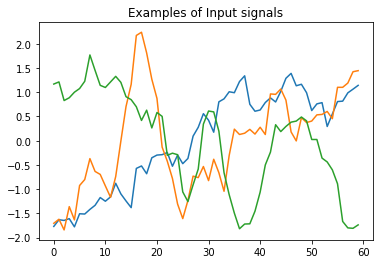

In [5]:
#Data visualization
plt.title('Examples of Input signals')
plt.plot(x[0])
plt.plot(x[1])
plt.plot(x[2])
plt.show()

In [6]:
reg = regularizers.l1(0.01)    
#Now we initialize the NN weights
ini = initializers.RandomNormal(mean=0,stddev=0.05)
conv_lay = lambda shape: Conv1D(filters =5, kernel_size =11, kernel_regularizer = reg, kernel_initializer = ini, activation = 'relu', input_shape = shape)

layers = [
    AveragePooling1D(5),
    Conv1D(filters=5,kernel_size=7,activation="relu"),
    Flatten(),
    Dense(10,activation='relu'),
    Dropout(0.2)]


model = build_model(keras.losses.categorical_crossentropy,conv_lay(input_shape), layers, 3)
                    
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d (AveragePo (None, 10, 5)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4, 5)              180       
_________________________________________________________________
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [7]:
batch_size =250
epochs = 100

fit = model.fit(x_train,y_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x_val,y_val),
               verbose=2, shuffle=True)

Epoch 1/100
32/32 - 2s - loss: 1.1139 - accuracy: 0.3525 - val_loss: 1.1040 - val_accuracy: 0.4070
Epoch 2/100
32/32 - 2s - loss: 1.0982 - accuracy: 0.3945 - val_loss: 1.0897 - val_accuracy: 0.4140
Epoch 3/100
32/32 - 1s - loss: 1.0830 - accuracy: 0.4074 - val_loss: 1.0742 - val_accuracy: 0.4255
Epoch 4/100
32/32 - 1s - loss: 1.0690 - accuracy: 0.4317 - val_loss: 1.0568 - val_accuracy: 0.4640
Epoch 5/100
32/32 - 1s - loss: 1.0499 - accuracy: 0.4545 - val_loss: 1.0351 - val_accuracy: 0.4910
Epoch 6/100
32/32 - 1s - loss: 1.0285 - accuracy: 0.4696 - val_loss: 1.0143 - val_accuracy: 0.5145
Epoch 7/100
32/32 - 2s - loss: 1.0072 - accuracy: 0.4856 - val_loss: 0.9910 - val_accuracy: 0.5085
Epoch 8/100
32/32 - 1s - loss: 0.9887 - accuracy: 0.5086 - val_loss: 0.9771 - val_accuracy: 0.5110
Epoch 9/100
32/32 - 1s - loss: 0.9756 - accuracy: 0.5024 - val_loss: 0.9592 - val_accuracy: 0.5320
Epoch 10/100
32/32 - 1s - loss: 0.9571 - accuracy: 0.5176 - val_loss: 0.9472 - val_accuracy: 0.5480
Epoch 11/

32/32 - 1s - loss: 0.6542 - accuracy: 0.7526 - val_loss: 0.6616 - val_accuracy: 0.7435
Epoch 84/100
32/32 - 1s - loss: 0.6580 - accuracy: 0.7563 - val_loss: 0.6546 - val_accuracy: 0.7500
Epoch 85/100
32/32 - 1s - loss: 0.6585 - accuracy: 0.7523 - val_loss: 0.6586 - val_accuracy: 0.7455
Epoch 86/100
32/32 - 1s - loss: 0.6521 - accuracy: 0.7520 - val_loss: 0.6483 - val_accuracy: 0.7575
Epoch 87/100
32/32 - 1s - loss: 0.6526 - accuracy: 0.7476 - val_loss: 0.6452 - val_accuracy: 0.7585
Epoch 88/100
32/32 - 1s - loss: 0.6548 - accuracy: 0.7539 - val_loss: 0.6467 - val_accuracy: 0.7655
Epoch 89/100
32/32 - 1s - loss: 0.6459 - accuracy: 0.7590 - val_loss: 0.6386 - val_accuracy: 0.7605
Epoch 90/100
32/32 - 1s - loss: 0.6399 - accuracy: 0.7595 - val_loss: 0.6363 - val_accuracy: 0.7650
Epoch 91/100
32/32 - 1s - loss: 0.6334 - accuracy: 0.7636 - val_loss: 0.6355 - val_accuracy: 0.7685
Epoch 92/100
32/32 - 1s - loss: 0.6354 - accuracy: 0.7653 - val_loss: 0.6358 - val_accuracy: 0.7650
Epoch 93/100


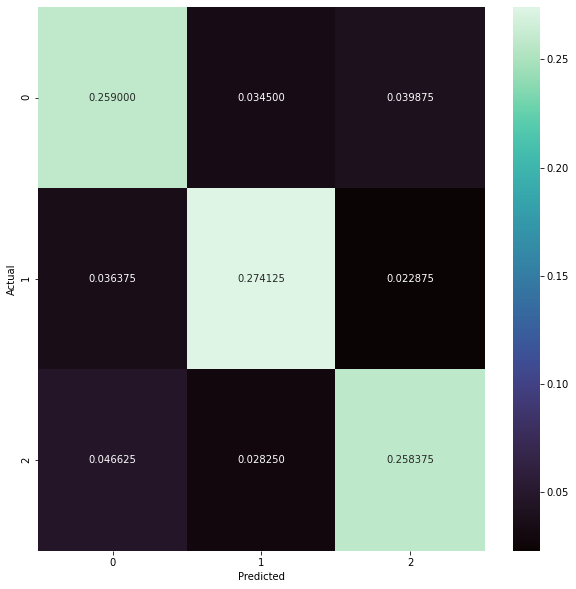

In [8]:
results = model.predict(x_train)
plot_confusionmatrix(results,y_train, normalization = True)

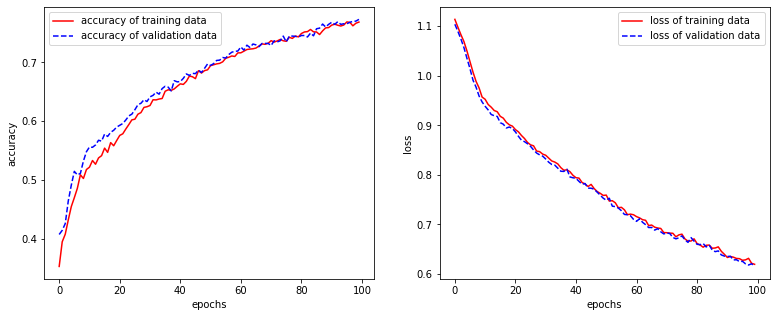

In [9]:

plot_accuracyloss(fit)

## 2 
By reducing the signal-to-noise ratio, namely the
amplitude of the external signal in the data (A) with
respect to the step typical size DX of the jump process,
check where the network (defined in the class) starts to
fail discriminating the categories.


In [10]:
#Re-seeding
seed(12345)
tensorflow.random.set_seed(12345)

In [11]:
x1,y1,N1 = data_import("DATA/x_ts_L60_Z12_A10_DX50_bias5_N10000.csv","DATA/y_ts_L60_Z12_A10_DX50_bias5_N10000.csv")
x2,y2,N2 = data_import("DATA/x_ts_L60_Z12_A100_DX50_bias5_N10000.csv","DATA/y_ts_L60_Z12_A100_DX50_bias5_N10000.csv")
x3,y3,N3 = data_import("DATA/x_ts_L60_Z12_A1000_DX50_bias5_N10000.csv","DATA/y_ts_L60_Z12_A1000_DX50_bias5_N10000.csv")
x4,y4,N4 = data_import("DATA/x_ts_L60_Z12_A10000_DX50_bias5_N10000.csv","DATA/y_ts_L60_Z12_A10000_DX50_bias5_N10000.csv")


Length of x =  10000
Length of x =  10000
Length of x =  10000
Length of x =  10000


In [13]:
x1 = data_process(x1,N1)
x2 = data_process(x2,N2)
x3 = data_process(x3,N3)
x4 = data_process(x4,N4)

x1_train, y1_train, x1_val, y1_val, input_shape1 = set_spliting(N1,x1,y1,perc_train = 0.8)
x2_train, y2_train, x2_val, y2_val, input_shape2 = set_spliting(N2,x2,y2,perc_train = 0.8)
x3_train, y3_train, x3_val, y3_val, input_shape3 = set_spliting(N3,x3,y3,perc_train = 0.8)
x4_train, y4_train, x4_val, y4_val, input_shape4 = set_spliting(N4,x4,y4,perc_train = 0.8)

In [14]:
batch_size =250
epochs = 100


fit1 = build_model(keras.losses.categorical_crossentropy,conv_lay(input_shape1),layers,3).fit(x1_train,y1_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x1_val,y1_val),
               verbose=2, shuffle=True)

fit2 = build_model(keras.losses.categorical_crossentropy,conv_lay(input_shape2),layers,3).fit(x2_train,y2_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x2_val,y2_val),
               verbose=2, shuffle=True)

fit3 = build_model(keras.losses.categorical_crossentropy,conv_lay(input_shape3),layers,3).fit(x3_train,y3_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x3_val,y3_val),
               verbose=2, shuffle=True)

fit4 = build_model(keras.losses.categorical_crossentropy,conv_lay(input_shape4),layers,3).fit(x4_train,y4_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x4_val,y4_val),
               verbose=2, shuffle=True)

Epoch 1/100
32/32 - 1s - loss: 1.1301 - accuracy: 0.3440 - val_loss: 1.1175 - val_accuracy: 0.3235
Epoch 2/100
32/32 - 1s - loss: 1.1094 - accuracy: 0.3406 - val_loss: 1.1058 - val_accuracy: 0.3265
Epoch 3/100
32/32 - 2s - loss: 1.1038 - accuracy: 0.3402 - val_loss: 1.1017 - val_accuracy: 0.3420
Epoch 4/100
32/32 - 1s - loss: 1.1022 - accuracy: 0.3352 - val_loss: 1.1012 - val_accuracy: 0.3340
Epoch 5/100
32/32 - 1s - loss: 1.1009 - accuracy: 0.3372 - val_loss: 1.0997 - val_accuracy: 0.3355
Epoch 6/100
32/32 - 2s - loss: 1.1012 - accuracy: 0.3275 - val_loss: 1.0995 - val_accuracy: 0.3400
Epoch 7/100
32/32 - 2s - loss: 1.0996 - accuracy: 0.3351 - val_loss: 1.0995 - val_accuracy: 0.3285
Epoch 8/100
32/32 - 1s - loss: 1.0994 - accuracy: 0.3346 - val_loss: 1.0989 - val_accuracy: 0.3330
Epoch 9/100
32/32 - 2s - loss: 1.0992 - accuracy: 0.3358 - val_loss: 1.1001 - val_accuracy: 0.3360
Epoch 10/100
32/32 - 2s - loss: 1.0997 - accuracy: 0.3288 - val_loss: 1.0988 - val_accuracy: 0.3300
Epoch 11/

32/32 - 1s - loss: 1.0987 - accuracy: 0.3372 - val_loss: 1.0987 - val_accuracy: 0.3330
Epoch 84/100
32/32 - 1s - loss: 1.0988 - accuracy: 0.3307 - val_loss: 1.0987 - val_accuracy: 0.3390
Epoch 85/100
32/32 - 2s - loss: 1.0988 - accuracy: 0.3301 - val_loss: 1.0987 - val_accuracy: 0.3335
Epoch 86/100
32/32 - 2s - loss: 1.0987 - accuracy: 0.3361 - val_loss: 1.0987 - val_accuracy: 0.3335
Epoch 87/100
32/32 - 2s - loss: 1.0988 - accuracy: 0.3294 - val_loss: 1.0987 - val_accuracy: 0.3335
Epoch 88/100
32/32 - 1s - loss: 1.0988 - accuracy: 0.3279 - val_loss: 1.0988 - val_accuracy: 0.3205
Epoch 89/100
32/32 - 1s - loss: 1.0988 - accuracy: 0.3329 - val_loss: 1.0988 - val_accuracy: 0.3395
Epoch 90/100
32/32 - 1s - loss: 1.0988 - accuracy: 0.3346 - val_loss: 1.0988 - val_accuracy: 0.3260
Epoch 91/100
32/32 - 1s - loss: 1.0988 - accuracy: 0.3324 - val_loss: 1.0987 - val_accuracy: 0.3330
Epoch 92/100
32/32 - 1s - loss: 1.0988 - accuracy: 0.3315 - val_loss: 1.0987 - val_accuracy: 0.3330
Epoch 93/100


Epoch 66/100
32/32 - 1s - loss: 1.0987 - accuracy: 0.3424 - val_loss: 1.0980 - val_accuracy: 0.3535
Epoch 67/100
32/32 - 1s - loss: 1.0985 - accuracy: 0.3435 - val_loss: 1.0981 - val_accuracy: 0.3485
Epoch 68/100
32/32 - 1s - loss: 1.0984 - accuracy: 0.3496 - val_loss: 1.0979 - val_accuracy: 0.3540
Epoch 69/100
32/32 - 1s - loss: 1.0987 - accuracy: 0.3397 - val_loss: 1.0985 - val_accuracy: 0.3450
Epoch 70/100
32/32 - 1s - loss: 1.0983 - accuracy: 0.3485 - val_loss: 1.0980 - val_accuracy: 0.3480
Epoch 71/100
32/32 - 1s - loss: 1.0987 - accuracy: 0.3397 - val_loss: 1.0983 - val_accuracy: 0.3450
Epoch 72/100
32/32 - 2s - loss: 1.0987 - accuracy: 0.3381 - val_loss: 1.0980 - val_accuracy: 0.3445
Epoch 73/100
32/32 - 1s - loss: 1.0987 - accuracy: 0.3456 - val_loss: 1.0980 - val_accuracy: 0.3485
Epoch 74/100
32/32 - 1s - loss: 1.0983 - accuracy: 0.3494 - val_loss: 1.0979 - val_accuracy: 0.3485
Epoch 75/100
32/32 - 2s - loss: 1.0987 - accuracy: 0.3415 - val_loss: 1.0980 - val_accuracy: 0.3525


32/32 - 1s - loss: 0.3406 - accuracy: 0.8915 - val_loss: 0.2770 - val_accuracy: 0.9135
Epoch 49/100
32/32 - 1s - loss: 0.3384 - accuracy: 0.8955 - val_loss: 0.2758 - val_accuracy: 0.9170
Epoch 50/100
32/32 - 1s - loss: 0.3345 - accuracy: 0.8936 - val_loss: 0.2727 - val_accuracy: 0.9185
Epoch 51/100
32/32 - 1s - loss: 0.3353 - accuracy: 0.8936 - val_loss: 0.2752 - val_accuracy: 0.9160
Epoch 52/100
32/32 - 1s - loss: 0.3409 - accuracy: 0.8956 - val_loss: 0.2718 - val_accuracy: 0.9185
Epoch 53/100
32/32 - 1s - loss: 0.3370 - accuracy: 0.8966 - val_loss: 0.2786 - val_accuracy: 0.9105
Epoch 54/100
32/32 - 1s - loss: 0.3442 - accuracy: 0.8919 - val_loss: 0.2747 - val_accuracy: 0.9135
Epoch 55/100
32/32 - 1s - loss: 0.3350 - accuracy: 0.8946 - val_loss: 0.2709 - val_accuracy: 0.9175
Epoch 56/100
32/32 - 1s - loss: 0.3324 - accuracy: 0.8980 - val_loss: 0.2675 - val_accuracy: 0.9205
Epoch 57/100
32/32 - 1s - loss: 0.3318 - accuracy: 0.8966 - val_loss: 0.2698 - val_accuracy: 0.9160
Epoch 58/100


Epoch 31/100
32/32 - 1s - loss: 0.0548 - accuracy: 0.9894 - val_loss: 0.0292 - val_accuracy: 0.9980
Epoch 32/100
32/32 - 1s - loss: 0.0531 - accuracy: 0.9900 - val_loss: 0.0295 - val_accuracy: 0.9980
Epoch 33/100
32/32 - 1s - loss: 0.0512 - accuracy: 0.9910 - val_loss: 0.0313 - val_accuracy: 0.9965
Epoch 34/100
32/32 - 1s - loss: 0.0531 - accuracy: 0.9902 - val_loss: 0.0281 - val_accuracy: 0.9985
Epoch 35/100
32/32 - 1s - loss: 0.0496 - accuracy: 0.9923 - val_loss: 0.0290 - val_accuracy: 0.9980
Epoch 36/100
32/32 - 1s - loss: 0.0512 - accuracy: 0.9902 - val_loss: 0.0282 - val_accuracy: 0.9985
Epoch 37/100
32/32 - 1s - loss: 0.0515 - accuracy: 0.9896 - val_loss: 0.0280 - val_accuracy: 0.9985
Epoch 38/100
32/32 - 1s - loss: 0.0499 - accuracy: 0.9898 - val_loss: 0.0268 - val_accuracy: 0.9990
Epoch 39/100
32/32 - 1s - loss: 0.0501 - accuracy: 0.9910 - val_loss: 0.0262 - val_accuracy: 0.9985
Epoch 40/100
32/32 - 1s - loss: 0.0502 - accuracy: 0.9912 - val_loss: 0.0278 - val_accuracy: 0.9980


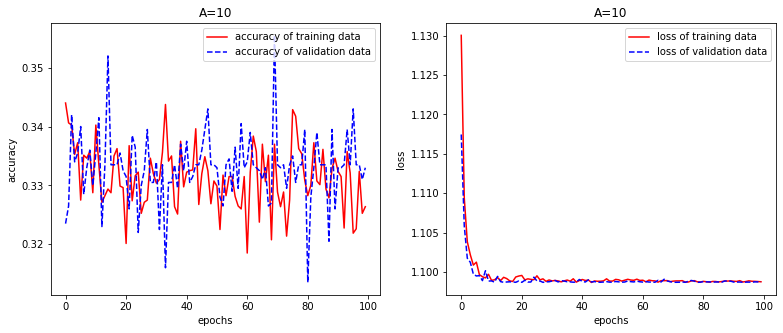

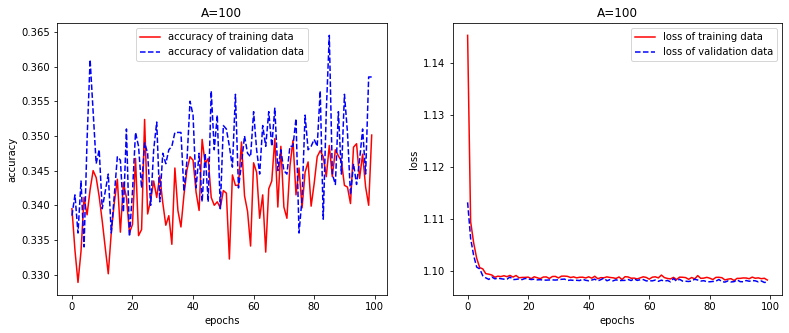

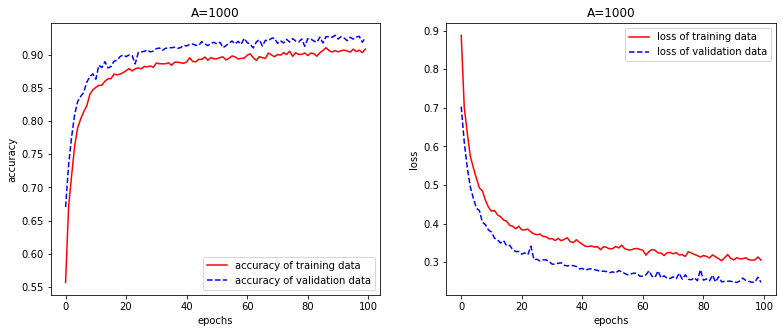

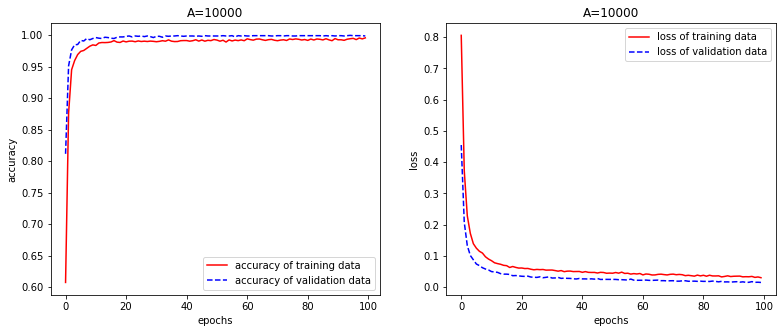

In [15]:
fits =        [fit1,fit2,fit3,fit4]
pattern_mag = [10,100,1000,10000]
for i in range(len(fits)):
    plot_accuracyloss(fits[i],title='A='+str(pattern_mag[i]))

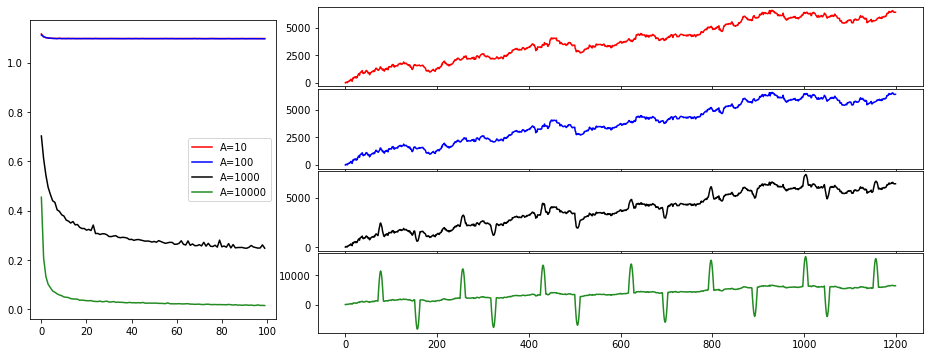

In [16]:
import matplotlib.gridspec as gridspec
pltxs = [pltx1,pltx2,pltx3,pltx4]
plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(24, 25)
for k in range(len(xs)): 
    axs[k] = plt.subplot(gs[6*k:6*k+6, 8:])
    for j in range(20):
        axs[k].plot([i for i in range(j*len(pltxs[k][0]),(len(pltxs[k][0])+j*len(pltxs[k][0])))],pltxs[k][j],color=colors[k])
        #axs[k].set_ylim(-10500,20000)
axloss = plt.subplot(gs[1:-1, :7])
for i in range(len(fits)):
    axloss.plot(fits[i].history['val_loss'],c=colors[i],label='A='+str(pattern_mag[i]))
    axloss.legend()

3. Try another version where only one convolutional layer is
introduced instead of two, and where any number of
dense layers may be used, with the global constraint of
using a network with at most $600$ trainable parameters.

Is the number of parameters scaling more quickly by adding Dense layers or Conv1D
layers?

In [ ]:

x, y, N = data_import("DATA/x_ts_comp_N10000.csv","DATA/y_ts_comp_N10000.csv")
x = data_process(x,N)
x_train, y_train, x_val, y_val, input_shape = set_spliting(N,x,y)
output_size =len(y_train[0])

In [ ]:
# Build the model

reg = regularizers.l1(0.01)
#Now we initialize the NN weights
ini = initializers.RandomNormal(mean=0,stddev=0.05)
layers = [AveragePooling1D(5),
          Flatten(),
          Dense(6,activation='relu'),
          Dropout(0.2),
          Dense(12,activation='relu'),
          Dense(9,activation='relu')]

model_1 = build_model(keras.losses.categorical_crossentropy,conv_lay(input_shape), layers, output_size)

print(model_1.summary())


In [ ]:
batch_size =250
epochs = 200

fit_1 = model_1.fit(x_train,y_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x_val,y_val),
               verbose=2, shuffle=True)

In [ ]:
results = model_1.predict(x_train)
plot_confusionmatrix(results,y_train, normalization = True)

In [ ]:
plot_accuracyloss(fit_1)

4. Check if regularization may improve the performances by varying the parameter lambda of
the L1 (LASSO) or of the L2 (Ridge) regularization; see lambda in eqs.(43) and (52) in the
review. There is also a mixed version (l1_l2) that can be tried.

    1. Is there any intermediate value of lambda where the performances of the network are better?

    2. Is there any improvement in the visualization and understanding of the weights in the filters?

Note that the regularization we introduced acts on the w’s, not on the biases. One can also
try the equivalent procedure for biases or for the output of the relu units (see Keras doc.), if
there is any reason for suspecting that it may help. In our case, the logic was to let the
weights of the filters go to zero if not needed, hence that kind of regularization was selected.

In [ ]:
from keras.regularizers import l1_l2
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


lam = np.logspace(0,-4,5).tolist()


In [ ]:
def reg_conv_lay(l1,l2):
    return Conv1D(filters =5, kernel_size =11, kernel_regularizer = l1_l2(l1 = l1, l2 = l2), kernel_initializer = ini, activation = 'relu', input_shape = input_shape)

def compile_model(l1,l2):

    model = build_model(keras.losses.categorical_crossentropy,reg_conv_lay(l1,l2),layers,output_size)
    
    return model

# Using Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model, 
                        epochs=200,
                        batch_size = 250, 
                        verbose=2)

# parameters dictionary
param_grid = dict(l1 = lam,l2=lam)
# Run gridsearch
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)
grid_result = grid.fit(x_train,y_train)

# summarize results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
best_model = grid_result.best_estimator_

EXTRA: If there is time, draw the confusion matrix for a CNN model trained with the sequence data of the
exercise 02.

In [ ]:
#File importation
ex_x, ex_y, ex_N = data_import("DATA/sequences16_x_augmented.csv",
                      "DATA/sequences16_y_augmented.csv")
ex_x = data_process(ex_x,ex_N)

#Now we permutate the samples 
permutation = np.random.permutation(ex_x.shape[0])

ex_x = ex_x[permutation] 
ex_y = ex_y[permutation]

ex_x_train, ex_y_train, ex_x_val, ex_y_val, ex_input_shape = set_spliting(ex_N,ex_x,ex_y,perc_train = 0.8)

ex_N_categ = len(np.unique(ex_y[0]))

In [ ]:
# Now we train the best CNN using the data of ex2

## TODO: build a model and train it

In [ ]:
reg = regularizers.l1(0.01)    
#Now we initialize the NN weights
ini = initializers.RandomNormal(mean=0,stddev=0.05)
conv_lay = lambda shape: Conv1D(filters =5, kernel_size =11, kernel_regularizer = reg, kernel_initializer = ini, activation = 'relu', input_shape = shape)

layers = [
    #AveragePooling1D(5),
    Conv1D(filters=5,kernel_size=7,activation="relu"),
    Flatten(),
    Dense(10,activation='relu'),
    Dropout(0.2)]

                             #Binary cross entropy is used
ex_model = build_model(keras.losses.binary_crossentropy,conv_lay(ex_input_shape), layers, ex_N_categ)

print(ex_model.summary())

In [ ]:
batch_size =250
epochs = 50

ex_fit = ex_model.fit(ex_x_train,ex_y_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(ex_x_val,ex_y_val),
               verbose=2, shuffle=True)

In [ ]:
ex_results = ex_model.predict(ex_x_train)
plot_confusionmatrix(ex_results,ex_y_train, normalization = False)

In [ ]:
plot_accuracyloss(ex_fit, title = False)